# Assingment 1

> Name: Milind Shaileshkumar Parvatia

> Sid: s3806853

## **Importing Libraries**

Importing All libraries for this project

In [1]:
import os
import pathlib
import shutil
import tempfile
from os import walk
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import display, HTML

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import PReLU, LeakyReLU

pd.set_option('display.max_columns', None)

AUTOTUNE=tf.data.experimental.AUTOTUNE

### Retriving files from Github Repository

In [2]:
# Clone the entire repo.
!git clone -l -s git://github.com/milindparvatia/DL-Assingment-1.git
%cd DL-Assingment-1
!ls

Cloning into 'DL-Assingment-1'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 3167 (delta 0), reused 3 (delta 0), pack-reused 3162
Receiving objects: 100% (3167/3167), 283.39 MiB | 35.06 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Checking out files: 100% (3080/3080), done.
/kaggle/working/DL-Assingment-1
Assingment-1.ipynb	  faces			    sageMaker
COSC2779_Assignment1.pdf  logs			    test_data.csv
LICENSE			  rubric-assignment1-1.pdf  train_data.csv
Readme.md		  s1234567_predictions.csv  training_checkpoints


## **Tensorboard**

Tensorboard is used to present all the output matrix created using tensorflow in this notebook.

In [3]:
os.mkdir(os.getcwd()+'/tensorboard_logs')

In [4]:
logdir = pathlib.Path("/tensorboard_logs")
#pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/models

## **Dataset**

Head Pose Image Database

The data for this assignment is a modified version of the data available at: [Head Pose Image Database](http://www-prima.inrialpes.fr/perso/Gourier/Faces/HPDatabase.html)

**Licence agreement: The dataset can only be used for the purpose of this assignment. Sharing or distributing this data or using this data for any other commercial or non-commercial purposes is prohibited.**

The head pose database is a benchmark of 2790 monocular face images of 15 persons with variations of pan and tilt angles from -90 to +90 degrees. For every person, 2 series of 93 images (93 different poses) are available. The purpose of having 2 series per person is to be able to train and test algorithms on known and unknown faces (cf. sections 2 and 3). People in the database wear glasses or not and have various skin colour. Background is willingly neutral and uncluttered in order to focus on face operations.

The image dimensions are [192,144]

**Tilt (Vertical angle)** = {-90, -60, -30, -15, 0, +15, +30, +60, +90},  
Negative values - bottom, Positive values - top;


**Pan (Horizontal angle)** = {-90, -75, -60, -45, -30, -15, 0, +15, +30, +45, +60, +75, +90},  
Negative values - left, Positive values - right;

### 1) Training dataset

In [5]:
train_df = pd.read_csv('train_data.csv')
train_df.head()

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


In [6]:
#printing shape of dataset
print("Shape of training dataset:",train_df.shape)

Shape of training dataset: (2325, 5)


### 2) Testing Dataset

In [7]:
test_df = pd.read_csv('test_data.csv')
test_df.head()

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


In [8]:
#printing shape of dataset
print("Shape of testing dataset:",test_df.shape)

Shape of testing dataset: (465, 3)


### 3) Accessing Images

All the images are in directory modified_data, to access Images I have created common method. It reads all the files in modified_data_, and copy them into new folder 'faces', it rename all images by removing 'face_' from it and only allows image numbers as file name.(I took this steps because tensorflow only accepts integers as filepath for creating tensors.)

I also replace both training and testing dataset from 'face_Int.jpg' to 'Int.jpg'.

In [9]:
# used following cmd to get path for current folder
curr_dir = os.getcwd()
image_names = []

if os.path.exists(curr_dir+"/faces"):
    images_dir = curr_dir+"/faces"
    
    for (dirpath, dirnames, filenames) in walk(images_dir):
        image_names.extend(filenames)
        break

    for i, name in enumerate(image_names):
        train_df['filename'] = train_df['filename'].replace('face_'+str(name), name)
        test_df['filename'] = test_df['filename'].replace('face_'+str(name), name)

else:
    os.mkdir('faces')
    images_dir = pathlib.Path(curr_dir+"/modified_data")
    
    for (dirpath, dirnames, filenames) in walk(images_dir):
        image_names.extend(filenames)
        break
            
    for i, name in enumerate(image_names):
        new_name = "_".join(name.split('_')[1:2])
        
        old_path = str(images_dir)+"/"+name
        new_path = os.path.join(curr_dir+"/faces/", new_name)
        os.rename(old_path, new_path)
        
        train_df['filename'] = train_df['filename'].replace(str(name), new_name)
        test_df['filename'] = test_df['filename'].replace(str(name), new_name)
        
    images_dir = curr_dir+"/faces/"
    
train_image_count = len(list(pathlib.Path(images_dir).glob('*.jpg')))
print("Total numbers of Images we have to process are",train_image_count)

Total numbers of Images we have to process are 2790


In [10]:
## I have convert filenames to int to make it easier to fill into tf.data

print("New filename in test_df dataset")
test_df.head()

New filename in test_df dataset


,filename,person_id,series
0,33.jpg,2,1
1,2148.jpg,2,2
2,2119.jpg,2,1
3,1262.jpg,2,1
4,516.jpg,2,2


Let's look at our image dataset with tilt and pan values.

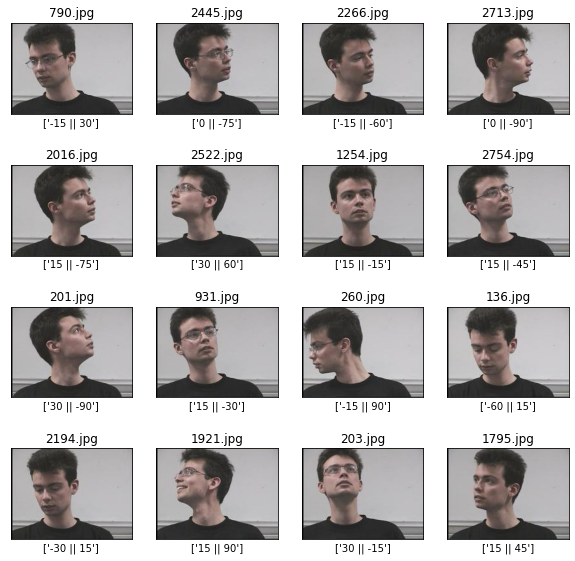

In [11]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = mpimg.imread(str(images_dir)+'/'+train_df['filename'].iloc[i]) # images are color images
    plt.imshow(image)
    
    plt.title(train_df['filename'].iloc[i])
    plt.xlabel([ str(train_df['tilt'].iloc[i])+' || '+str(train_df['pan'].iloc[i]) ])

plt.show()

## **Data Preparation**

### 1) Cleaning datasets

In [12]:
train_df.isnull().sum()

filename     0
person_id    0
series       0
tilt         0
pan          0
dtype: int64

In [13]:
test_df.isnull().sum()

filename     0
person_id    0
series       0
dtype: int64

From the above measurements we can conclude that the Given datasets have zero null values and are in perfect condition for further processing.

### 2) Checking Frequencies of Labels

Showing Label Distribution so we can get better idea what type of data we are dealing.

 15    325
-15    325
 60    325
-60    325
 30    325
-30    325
 0     325
 90     25
-90     25
Name: tilt, dtype: int64

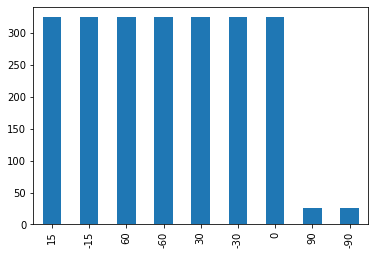

In [14]:
fig, ax = plt.subplots()
train_df['tilt'].value_counts().plot(ax=ax, kind='bar')
train_df['tilt'].value_counts()

 0     225
 75    175
-75    175
 45    175
-45    175
 15    175
-15    175
 90    175
-90    175
 60    175
-60    175
 30    175
-30    175
Name: pan, dtype: int64

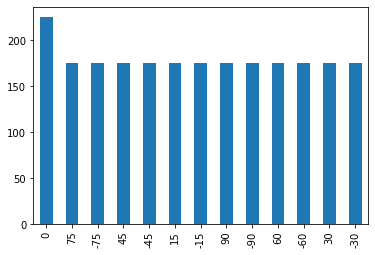

In [15]:
fig, ax = plt.subplots()
train_df['pan'].value_counts().plot(ax=ax, kind='bar')
train_df['pan'].value_counts()

Here we can see that our target features are imbalanced, but for this project [I am ignoring imbalnced data, since I'm going to use ADAM optimizer.](https://stats.stackexchange.com/questions/283170/when-is-unbalanced-data-really-a-problem-in-machine-learning)

## One Hot Encoding of target value

For encoding I have used One hot Encoder from sklearn library which convert only classes to 1 if present otherwise convert them to 0.

In [16]:
from sklearn.preprocessing import OneHotEncoder

def ohe(x):
    return OneHotEncoder(categories='auto').fit(x.reshape(-1,1)).transform(x.reshape(-1,1)).toarray().astype('int64')

### 1) OneHotEncoding of Tilt

Tilt column have 9 diffrent values which are {-90, -60, -30, -15, 0, +15, +30, +60, +90} so when we performs OneHotEncoding it creates 9 columns with every column representing one label of tilt angle.

In [17]:
y_tilt = pd.DataFrame(ohe(np.array(train_df.tilt)))
y_tilt.shape

(2325, 9)

### 2) OneHotEncoding of Pan

Pan have 13 diffrent values {-90, -75, -60, -45, -30, -15, 0, +15, +30, +45, +60, +75, +90} so it will creates 13 diffrent columns.

In [18]:
y_pan = pd.DataFrame(ohe(np.array(train_df.pan)))
y_pan.shape

(2325, 13)

### 3) Creating Target values

for this problem I have merged two target values into single numpy array so that we can pass it to train_test_split method of sklearn.

In [19]:
targets = np.concatenate((y_tilt, y_pan), axis=1)
targets[:3]

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [20]:
print("Shape of target numpy array:",targets.shape)

Shape of target numpy array: (2325, 22)


## **Training-Validation data split from train_df dataset**

Here I have used train_test_split from sklearn with startify to shuffle dataset before spliting them into training and validation dataset for model.

I have used test_size = 0.2 which will splits 80% for training data and 20% for validating data.

In [21]:
def train_test_splits(X,y): 
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=292, shuffle=True, stratify=y)
    return x_train, x_val, y_train, y_val

In [22]:
X_train, X_val, y_train, y_val = train_test_splits(train_df['filename'], targets)
X_test = test_df.filename

Adding image's file path as prefix to image names so that it can be retrived.

In [23]:
X_train = [os.path.join(images_dir, str(f)) for f in X_train]
X_val = [os.path.join(images_dir, str(f)) for f in X_val]

y_train = np.array(y_train)
y_val = np.array(y_val)

In [24]:
print("***************************")
print("Splits of Labels")
print("***************************")
print("Size of training: ", len(X_train))
print("Size of validation: ", len(X_val))
print("\n***************************")
print("Input Values:")
print("***************************")
print(X_train[:3])
print("\n***************************")
print("Target Values:")
print("***************************")
print(y_train[:3])

***************************
Splits of Labels
***************************
Size of training:  1860
Size of validation:  465

***************************
Input Values:
***************************
['/kaggle/working/DL-Assingment-1/faces/2431.jpg', '/kaggle/working/DL-Assingment-1/faces/2211.jpg', '/kaggle/working/DL-Assingment-1/faces/2021.jpg']

***************************
Target Values:
***************************
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]]


## **Data pipeline**

To fully use gpu for training I have used tensorflow's Distributed Mirrored Strategy which make it easier for training models most efficient way on gpu.

In [25]:
strategy = tf.distribute.MirroredStrategy()

In [26]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


I have created data pipeline for easier approch for creating tensors, in one go, Using this mehtods, I have created tensor of <(training data),(target(tilt),(target(pan))>.

Since our number of training images are very less for deep learning problem, I have used Ausgmentation of images to create variasions of imaeges for more complexity. I have used following augmentation,

1. random_brightness
2. random_saturation
3. random_hue

In [27]:
BUFFER_SIZE = 128
IMG_HEIGHT = 144
IMG_WIDTH = 192
BATCH_SIZE_PER_REPLICA = 256
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [28]:
# pipeline for training and validation datasets
def data_pipeline(X, y, augmenting=False):
    filenames = tf.convert_to_tensor(X, dtype=tf.string)
    label1 = tf.convert_to_tensor(y[:, :9])
    label2 = tf.convert_to_tensor(y[:, 9:22])
    dataset = tf.data.Dataset.from_tensor_slices((filenames, (label1, label2)))
    
    def map_fn(path, label):
        # path/label represent values for a single example
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        if augmenting:
          image = tf.image.random_brightness(image, 0.2)
          image = tf.image.random_saturation(image, 0, 4)
          image = tf.image.random_hue(image, 0.3)
        image = tf.cast(image, dtype=tf.float32) / 255.0
        image = tf.reshape(image, [144, 192, 3])
        image = tf.image.resize_with_crop_or_pad(image, 192, 192)
        return image, label

    # num_parallel_calls > 1 induces intra-batch shuffling
    dataset = dataset.map(map_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

# pipeline for testing datasets
def creating_test_pipeline(X):
    filenames = tf.convert_to_tensor(X, dtype=tf.string)
    dataset = tf.data.Dataset.from_tensor_slices((filenames))

    def map_test_fn(path):
      # path/label represent values for a single example
      image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
      image = tf.cast(image, dtype=tf.float32) / 255.0
      image = tf.reshape(image, [144, 192, 3])
      image = tf.image.resize_with_crop_or_pad(image, 192, 192)
      return image

    dataset = dataset.map(map_test_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [29]:
# Creating dataset for training on models with no augmentations
train_ds = data_pipeline(X_train,y_train).cache().repeat(BUFFER_SIZE).batch(BATCH_SIZE)

# Creating small dataset for training on model
train_ds_tiny = data_pipeline(
    X_train[:BATCH_SIZE],
    y_train[:BATCH_SIZE]
    ).cache().repeat(BUFFER_SIZE).batch(BATCH_SIZE)

# Creating dataset for training on models with augmentations
train_ds_aug = data_pipeline(X_train,y_train,True).cache().repeat(BUFFER_SIZE).batch(BATCH_SIZE)

# Creating full dataset for training on models with augmentations
full_train_ds_aug = data_pipeline(
    np.concatenate([X_train,X_val]),
    np.concatenate([y_train,y_val]),
    True
    ).cache().repeat(BUFFER_SIZE).batch(BATCH_SIZE)

# Creating Validation dataset for validation
val_ds = data_pipeline(X_val,y_val).batch(BATCH_SIZE)

# Crating Testing dataset for testing models after training 
test_ds = creating_test_pipeline(X_test).cache().repeat(BUFFER_SIZE).batch(BATCH_SIZE)

In [30]:
train_ds

<BatchDataset shapes: ((None, 192, 192, 3), ((None, 9), (None, 13))), types: (tf.float32, (tf.int64, tf.int64))>

let's see if image augmation works or not,

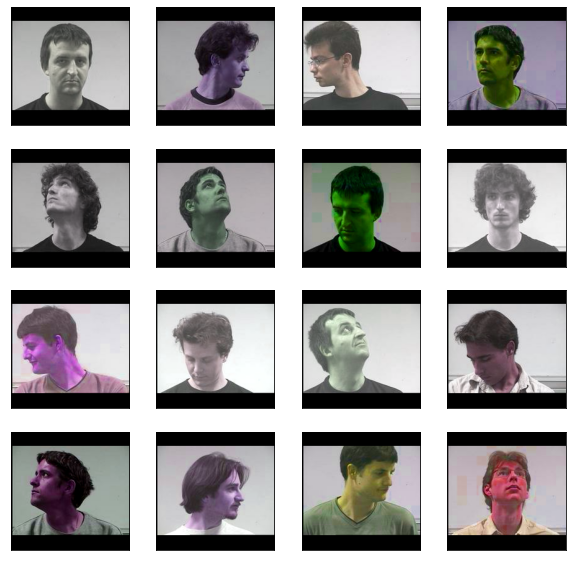

In [31]:
image, label = next(iter(train_ds_aug.batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    arr_ = np.squeeze(image[0][i])
    plt.imshow(arr_)
plt.show()

## Resnet Model

For predicting face's tilt and pan angle I have decided to use Resnet-34 which uses 34 layers Architecutre and it's one of the most common resnet. I have recreated the architecture following way.

---

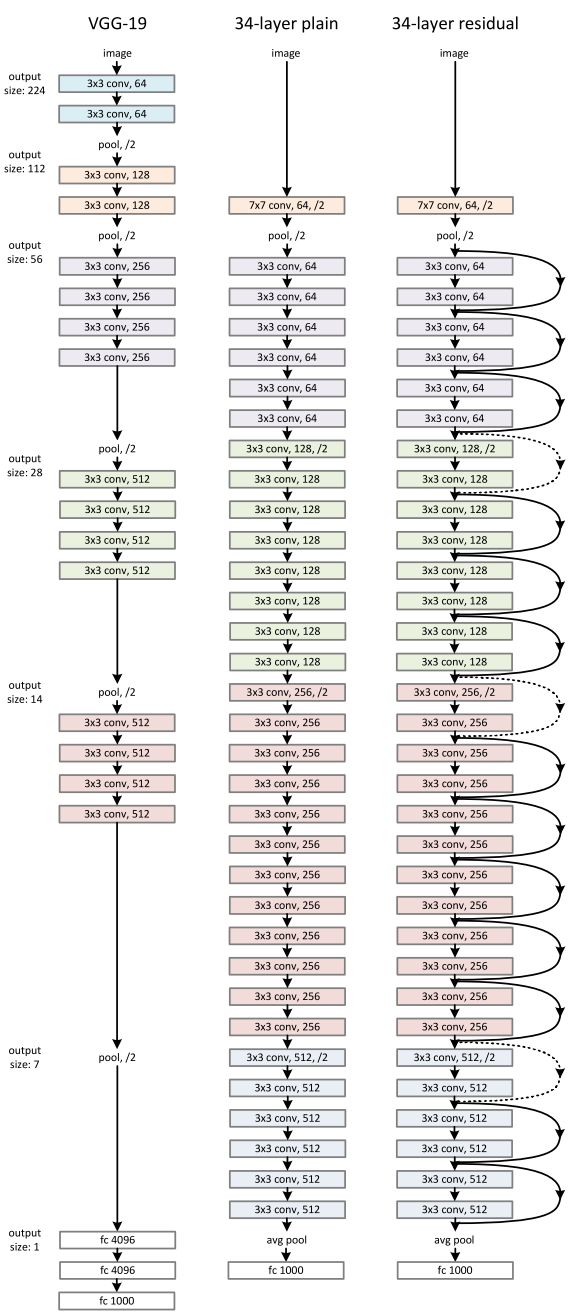

**Custom ResidualBlock for NN**, I have used following funtion to create custom ResidualBlock for NN which makes is more easier to experiment with hyperparameters and diffrent iterations of models.

In [32]:
class ResidualBlock(tf.keras.layers.Layer):

    # Initialize components of the model
    def __init__(self, filter_num, stride=1, reg_lambda=0.0):
        super(ResidualBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=stride,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn1 = tf.keras.layers.BatchNormalization(momentum=0.7)
        self.conv2 = tf.keras.layers.Conv2D(filters=filter_num,
                                            kernel_size=(3, 3),
                                            strides=1,
                                            kernel_initializer="he_normal",
                                            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                            padding="same")
        self.bn2 = tf.keras.layers.BatchNormalization(momentum=0.7)
        if stride != 1:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv2D(filters=filter_num,
                                                       kernel_size=(1, 1),
                                                       kernel_initializer="he_normal",
                                                       kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
                                                       strides=stride))
            self.downsample.add(tf.keras.layers.BatchNormalization(momentum=0.7))
        else:
            self.downsample = lambda x: x

    # Define the forward function
    def call(self, inputs, training=None, **kwargs):
        residual = self.downsample(inputs)

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x, training=training)

        output = tf.nn.relu(tf.keras.layers.add([residual, x]))

        return output

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'conv1': self.conv1,
            'bn1': self.bn1,
            'conv2': self.conv2,
            'bn2': self.bn2,
            'downsample': self.downsample,
        })
        return config

This function is created to return resnet model with desiered NN layers.

In [33]:
def get_resnet_model(filters, block_size, reg_lambda=0.0):
  model_input = Input(shape=(192, 192, 3))
  #initial segment
  x = Conv2D(filters=64,
            kernel_size=(7,7),
            strides=1,
            kernel_initializer="he_normal",
            kernel_regularizer=tf.keras.regularizers.l2(reg_lambda),
            padding="same"
            )(model_input)
  x = BatchNormalization(momentum=0.7)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3,3))(x)

  #Stack of residual blocks
  for nFilters, nBlocks in zip(filters, block_size):
    x = ResidualBlock(nFilters, stride=2, reg_lambda=reg_lambda)(x)
    
    for _ in range(1, nBlocks):
      x = ResidualBlock(nFilters, stride=1, reg_lambda=reg_lambda)(x)

  # Final part
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Flatten()(x)

  y1 = tf.keras.layers.Dense(9, activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), kernel_initializer="he_normal")(x)
  y2 = tf.keras.layers.Dense(13, activation=tf.nn.softmax, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), kernel_initializer="he_normal")(x)
  
  model = Model(inputs=model_input, outputs=[y1, y2])

  return model

* For Optimizer I have used Adam with learning rate decaying over the numbers of steps per epochs.

* I have used custom callbacks with early rate stopping, which stops the training if loss function stops improving.

* I have used tensorboards in callbacks to ceate outputs of matrix in more readeable manner.

In [34]:
checkpoint_dir = './training_checkpoints'
# # Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

def get_callbacks(name, early_stop=True):
  if early_stop:
    return [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
            tf.keras.callbacks.TensorBoard("{}/{}".format(
                str(logdir), str(name)), histogram_freq=60, embeddings_freq=60),
#             tf.keras.callbacks.LearningRateScheduler(decay),
            ]
  else:
    return [
            tf.keras.callbacks.TensorBoard("{}/{}".format(str(logdir), str(name))),
    ]

I have used custom plotter funtion to plot the model output of matrixes after fitting in training for better comparision.

In [35]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

## Model Training

In [36]:
from tensorflow.keras.optimizers import Adam

STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE

lr = 0.001

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  lr,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False
  )

optimizer = Adam(learning_rate=lr_schedule)

epoch_size = 250


## Sanity Check

* Before working on main model, I have performed sanity check to see it the data processed is working on model or not.

* This way it makes easier for me to identify any error before actual model training which saves alot of time.

### 1) Tiny model

First I have tired training data on small model to check if it underfits or not.

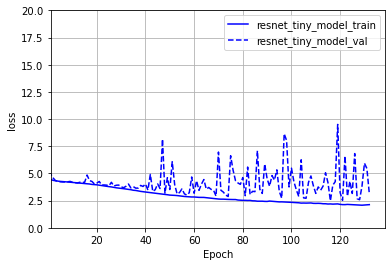

In [59]:
tiny_histories = {}

with strategy.scope():
  resnet_tiny_model = get_resnet_model([64], [1])
  resnet_tiny_model.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

tiny_histories['resnet_tiny_model'] = resnet_tiny_model.fit(
    train_ds,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/resnet_tiny_model')
)

plotter(tiny_histories, ylim=[0.0, 20], metric = 'loss')

### 2) Tiny Dataset

After that, I have used tiny dataset with small model to check if it is overfiting or not.

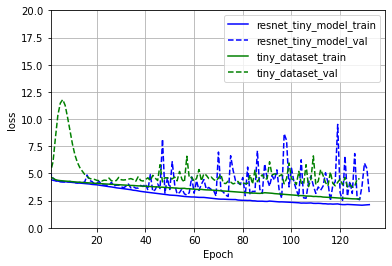

In [60]:
with strategy.scope(): 
  tiny_dataset = get_resnet_model([64], [1])
  tiny_dataset.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

tiny_histories['tiny_dataset'] = tiny_dataset.fit(
    train_ds_tiny,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = 1,
    validation_steps = 1,
    verbose=0,
    callbacks=get_callbacks('models/tiny_dataset')
)

plotter(tiny_histories, ylim=[0.0, 20], metric = 'loss')

Our dataset passed both tests so now we can starts actual model training.

## Base Model

---

For model training I have created a base model, which will be used thourout following trainings of models.

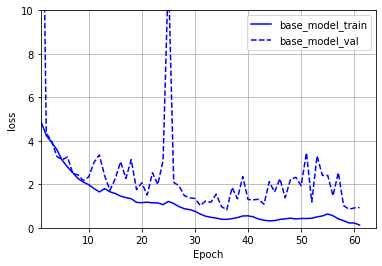

In [61]:
m_histories = {}

with strategy.scope(): 
  base_model = get_resnet_model([64,128,256,512], [3,4,6,3])
  base_model.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

m_histories['base_model'] = base_model.fit(
    train_ds,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/base_model')
)

plotter(m_histories, ylim=[0.0, 10], metric = 'loss')

* Since the dataset for the given problem is very small, even though the validation curve for based model is decreasing with training curve, my based model has very high variance.

* To reduce high varience I have tried following methods,
  1. Data Augmentation
  2. Regularisation
  3. Raise momentum in BatchNormalizer since model is not learning enough

### 1) Data Augmentation

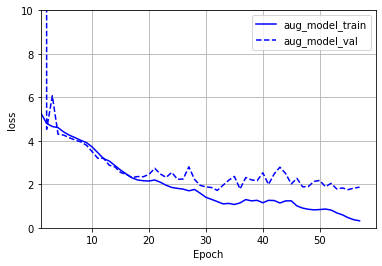

In [64]:
da_histories = {}

with strategy.scope(): 
  aug_model = get_resnet_model([64,128,256,512], [3,4,6,3])
  aug_model.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

da_histories['aug_model'] = aug_model.fit(
    train_ds_aug,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/aug_model')
)

plotter(da_histories, ylim=[0.0, 10], metric = 'loss')

### 2) Regularization

* To find Regularization value I have used this custome function which will test out all the Hyper Parameters as argument one by one and print out plot of Lambda vs. Category Cross-entropy below.

In [73]:
r_histories = {}

# lambda_vals = [1e-05, 1e-06, 2e-07,1e-07,5e-08,1e-08]
lambda_vals = [0.001 ,0.0001, 0.00001, 0.000002, 0.0000002, 0.0000005]
for reg_lambda in lambda_vals:
  with strategy.scope(): 
    tiny_res_net = get_resnet_model([64,128,256,512], [3,4,6,3], reg_lambda=reg_lambda)
    tiny_res_net.compile(
        optimizer=optimizer, 
        experimental_steps_per_execution = 50,
        loss=[
              tf.losses.CategoricalCrossentropy(),
              tf.losses.CategoricalCrossentropy()
        ],
        metrics= ['accuracy'])

  r_histories['resnet_large_reg'+ '_h' + str(reg_lambda)] = tiny_res_net.fit(
    train_ds_aug,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/resnet_large_reg'+ '_h1' + str(reg_lambda), early_stop=False))

[0.001, 0.0001, 1e-05, 2e-06, 2e-07, 5e-07] [2.402233123779297, 0.9764494299888611, 0.20679815113544464, 0.04517700895667076, 0.005490071140229702, 0.011244549416005611]
[0.001, 0.0001, 1e-05, 2e-06, 2e-07, 5e-07] [4.245195388793945, 2.8276877403259277, 1.4854764938354492, 1.6765702962875366, 1.5268927812576294, 1.9974086284637451]


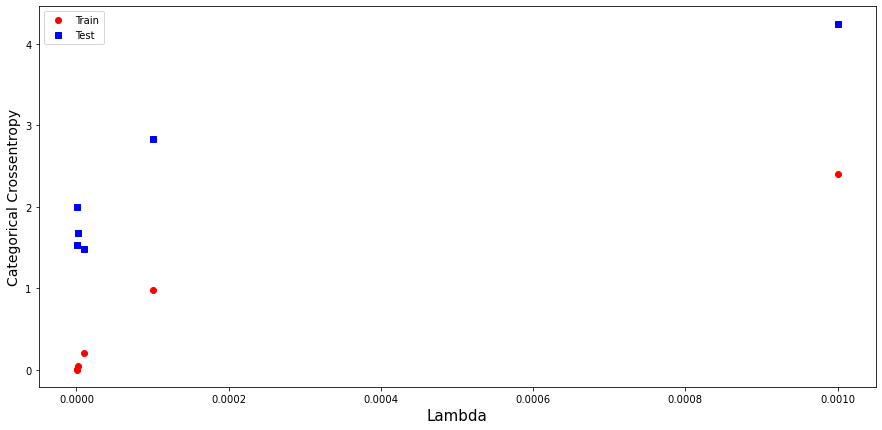

In [74]:
plt.figure(figsize=(15,7))
metric = 'loss'
m_train = list()
m_val = list()

for reg_lambda in lambda_vals:
  m_train.append(r_histories['resnet_large_reg'+ '_h' + str(reg_lambda)].history[metric][-1])
  m_val.append(r_histories['resnet_large_reg'+ '_h' + str(reg_lambda)].history['val_' + metric][-1])

print(lambda_vals,m_train)
print(lambda_vals,m_val)
plt.plot(lambda_vals,m_train, 'ro', label='Train' )
plt.plot(lambda_vals,m_val, 'bs', label='Test' )

plt.xlabel('Lambda', fontsize=15)
plt.ylabel('Categorical Crossentropy', fontsize=14)
plt.legend()
plt.show()

From this plot we can see that 2e-07 is most efficient hyper parameter for Regularization value.

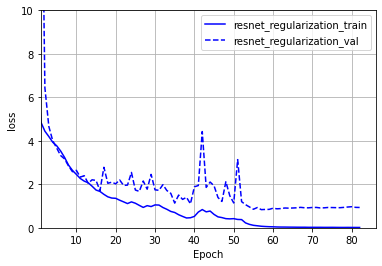

In [48]:
rg_histories = {}

with strategy.scope(): 
  resnet_regularization = get_resnet_model([64,128,256,512], [3,4,6,3], reg_lambda=2e-07)
  resnet_regularization.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

rg_histories['resnet_regularization'] = resnet_regularization.fit(
    train_ds_aug,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/resnet_regularization')
)

plotter(rg_histories, ylim=[0.0, 10], metric = 'loss')

### 3) Diffrent Models

Let's test this hyper-parameters with diffrent numbers of layers

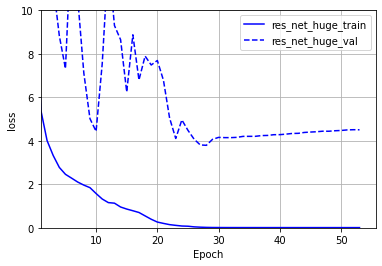

In [38]:
hm_histories = {}

with strategy.scope(): 
  # tiny_res_net = get_resnet_model([64,128,256,512], [6,6,6,6], reg_lambda=2e-7, fdropout=0.5)
  res_net_huge = get_resnet_model([64,128,256,512,1024,2048], [3,3,3,2,2,1], reg_lambda=2e-7)
  res_net_huge.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

hm_histories['res_net_huge'] = res_net_huge.fit(
    train_ds_aug,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/res_net_huge')
)

plotter(hm_histories, ylim=[0.0, 10], metric = 'loss')

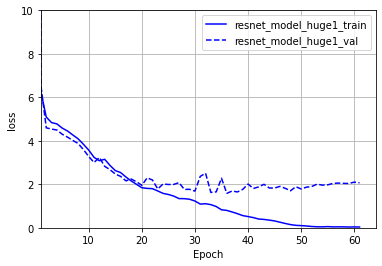

In [49]:
m1_histories = {}

with strategy.scope(): 
  resnet_model_huge1 = get_resnet_model([64,128,256,512,1024], [3,4,6,4,2], reg_lambda=2e-7)
  resnet_model_huge1.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

m1_histories['resnet_model_huge1'] = resnet_model_huge1.fit(
    train_ds_aug,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/resnet_model_huge1')
)

plotter(m1_histories, ylim=[0.0, 10], metric = 'loss')

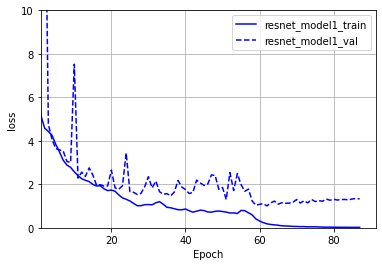

In [51]:
m1_histories = {}

with strategy.scope(): 
  resnet_model1 = get_resnet_model([64,128,256], [3,4,6], reg_lambda=2e-7)
  resnet_model1.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

m1_histories['resnet_model1'] = resnet_model1.fit(
    train_ds_aug,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/resnet_model1')
)

plotter(m1_histories, ylim=[0.0, 10], metric = 'loss')

From this we can esily say that for tilt, going deeper into layers with [64,128,256,512], [3,4,6,3], reg_lambda=2e-07 has best loss function.

## Final Models

### Model for Tilt

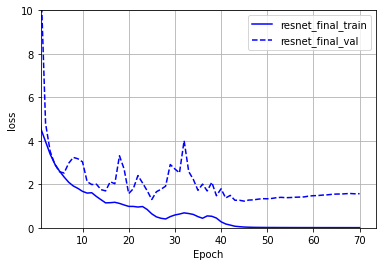

In [39]:
final_histories = {}

with strategy.scope(): 
  resnet_final = get_resnet_model([64,128,256,512], [3,4,6,3], reg_lambda=2e-07)
  resnet_final.compile(
      optimizer=optimizer, 
      loss=[
            tf.losses.CategoricalCrossentropy(),
            tf.losses.CategoricalCrossentropy()
      ],
      metrics= ['accuracy'])

final_histories['resnet_final'] = resnet_final.fit(
    train_ds_aug,
    epochs = epoch_size, 
    validation_data = (val_ds),
    steps_per_epoch = len(X_train)//BATCH_SIZE,
    validation_steps = len(X_val)//BATCH_SIZE,
    verbose=0,
    callbacks=get_callbacks('models/resnet_final')
)

plotter(final_histories, ylim=[0.0, 10], metric = 'loss')

## Predicting

Let's see how our final model is performing on full dataset with compared to other few models.

In [53]:
print(resnet_model_huge1.evaluate(full_train_ds_aug))
print(resnet_model1.evaluate(full_train_ds_aug))
print(resnet_final.evaluate(full_train_ds_aug))

1163/1163 [==============================] - 213s 183ms/step - loss: 1.6363 - dense_4_loss: 0.5080 - dense_5_loss: 1.1163 - dense_4_accuracy: 0.8637 - dense_5_accuracy: 0.6899
[1.636303424835205, 0.5080364942550659, 1.1162643432617188, 0.8636559247970581, 0.6898924708366394]
1163/1163 [==============================] - 181s 156ms/step - loss: 0.7314 - dense_6_loss: 0.2002 - dense_7_loss: 0.5277 - dense_6_accuracy: 0.9368 - dense_7_accuracy: 0.8404
[0.7313824892044067, 0.20016467571258545, 0.5277473330497742, 0.9367741942405701, 0.8404300808906555]
1163/1163 [==============================] - 192s 165ms/step - loss: 0.5853 - dense_2_loss: 0.1600 - dense_3_loss: 0.4206 - dense_2_accuracy: 0.9480 - dense_3_accuracy: 0.8804
[0.5852954983711243, 0.15999534726142883, 0.4206402003765106, 0.9479569792747498, 0.8804301023483276]


This function is created to predict angles of Images

In [54]:
def show_prediction(title):
    # Get movie info
    
    img_path = os.path.join(images_dir, str(title))

    # Read and prepare image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(144,192,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img, axis=0)

    # Generate prediction
    prediction = resnet_final.predict(img)
    
    predicted1 = np.argwhere(prediction[0] > 0.5).astype('int')
    predicted2 = np.argwhere(prediction[1] > 0.5).astype('int')
    
    prediction1 = pd.Series([-90, -60, -30, -15, 0, +15, +30, +60, +90])
    prediction2 = pd.Series([ -90, -75, -60, -45, -30, -15, 0, +15, +30, +45, +60, +75, +90])
    
    filename = title
    
    try:
      tilt = prediction1[predicted1[0][1]]
    except:
      tilt = None

    try:
      pan = prediction2[predicted2[0][1]]
    except:
      pan = None
    
    return [str(filename), tilt, pan]

In [55]:
titles = np.array(X_test)
test_predict = pd.DataFrame(columns=['filename', 'tilt', 'pan'])
data = []

for i in titles:
  data.append(show_prediction(i))

In [56]:
df = pd.DataFrame(data, columns=['filename', 'tilt', 'pan'])
df.head(10)

,filename,tilt,pan
0,33.jpg,60.0,-60.0
1,2148.jpg,30.0,-60.0
2,2119.jpg,-30.0,45.0
3,1262.jpg,15.0,-45.0
4,516.jpg,-30.0,-75.0
5,1530.jpg,30.0,NaN
6,464.jpg,60.0,-60.0
7,1971.jpg,30.0,-75.0
8,92.jpg,30.0,75.0
9,921.jpg,60.0,-60.0


Let's see our model's prediction

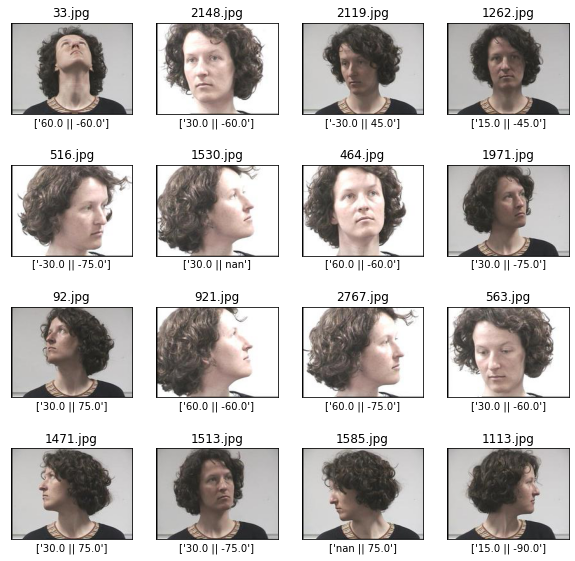

In [57]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = mpimg.imread(str(images_dir)+'/'+df['filename'].iloc[i]) # images are color images
    plt.imshow(image)
    
    plt.title(df['filename'].iloc[i])
    plt.xlabel([ str(df['tilt'].iloc[i])+' || '+str(df['pan'].iloc[i]) ])

plt.show()

Let's check how many prediction were filled with NAN

In [58]:
df.tilt.value_counts(dropna=False)

 30.0    181
-30.0     97
 15.0     49
 60.0     45
-60.0     35
-15.0     26
 NaN      23
 0.0       8
 90.0      1
Name: tilt, dtype: int64

In [59]:
df.pan.value_counts(dropna=False)

-60.0    85
-75.0    74
 45.0    64
 75.0    61
-45.0    55
-90.0    38
-30.0    19
 NaN     16
 15.0    12
-15.0    12
 0.0     11
 30.0    10
 90.0     6
 60.0     2
Name: pan, dtype: int64

For the marking porpose of assignment I have filled NAN with 0's

In [62]:
df = df.fillna(0)
df.head()

,filename,tilt,pan
0,33.jpg,60.0,-60.0
1,2148.jpg,30.0,-60.0
2,2119.jpg,-30.0,45.0
3,1262.jpg,15.0,-45.0
4,516.jpg,-30.0,-75.0


In [63]:
df.to_csv('s3806853_predictions.csv', encoding='utf-8')

In [64]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df)